In [27]:
import keras
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
housing = fetch_california_housing()

x_train_full, x_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, random_state=42)

In [4]:
# scaling
std_scaler = StandardScaler()
x_train = std_scaler.fit_transform(x_train)
x_valid = std_scaler.transform(x_valid)
x_test = std_scaler.transform(x_test)

In [5]:
x_train.shape, y_train.shape

((11610, 8), (11610,))

### modelling

In [6]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=x_train.shape[1:]),
    keras.layers.Dense(1)
])

In [7]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=0.001))
history = model.fit(x_train, y_train, epochs=40, validation_data=(x_valid, y_valid))
mse_test = model.evaluate(x_test, y_test)
x_new = x_test[:3]
y_pred = model.predict(x_new)

Epoch 1/40
363/363 [==============================] - 0s 590us/step - loss: 1.6466 - val_loss: 1.0811
Epoch 2/40
363/363 [==============================] - 0s 400us/step - loss: 0.7820 - val_loss: 0.7175
Epoch 3/40
363/363 [==============================] - 0s 402us/step - loss: 0.6708 - val_loss: 0.6405
Epoch 4/40
363/363 [==============================] - 0s 392us/step - loss: 0.6214 - val_loss: 0.5925
Epoch 5/40
363/363 [==============================] - 0s 390us/step - loss: 0.5864 - val_loss: 0.5569
Epoch 6/40
363/363 [==============================] - 0s 536us/step - loss: 0.5581 - val_loss: 0.5302
Epoch 7/40
363/363 [==============================] - 0s 390us/step - loss: 0.5346 - val_loss: 0.5038
Epoch 8/40
363/363 [==============================] - 0s 390us/step - loss: 0.5146 - val_loss: 0.4878
Epoch 9/40
363/363 [==============================] - 0s 390us/step - loss: 0.4975 - val_loss: 0.4694
Epoch 10/40
363/363 [==============================] - 0s 391us/step - loss: 0.482

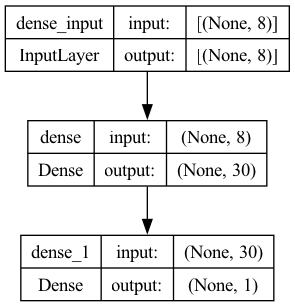

In [8]:
keras.utils.plot_model(model, "regression_model_california_sequential.png", show_shapes=True)

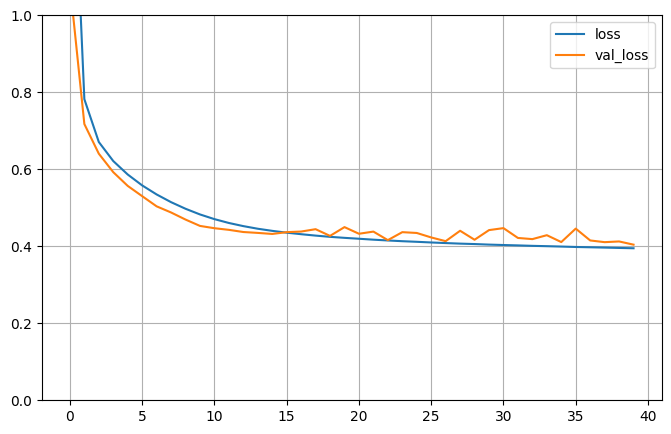

In [9]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Using functional API

### Wide part getting input directly concatenated with hidden 2 layer

In [10]:
input_ = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 30)                   270       ['input_1[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 30)                   930       ['dense_2[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 38)                   0         ['input_1[0][0]',             
                                                                     'dense_3[0][0]']         

In [12]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_valid, y_valid))
mse_test = model.evaluate(x_test, y_test)
y_pred = model.predict(x_new)

Epoch 1/20
363/363 [==============================] - 0s 595us/step - loss: 2.6056 - val_loss: 0.8500
Epoch 2/20
363/363 [==============================] - 0s 428us/step - loss: 0.7170 - val_loss: 0.6417
Epoch 3/20
363/363 [==============================] - 0s 433us/step - loss: 0.6220 - val_loss: 0.5737
Epoch 4/20
363/363 [==============================] - 0s 649us/step - loss: 0.5710 - val_loss: 0.5353
Epoch 5/20
363/363 [==============================] - 0s 426us/step - loss: 0.5329 - val_loss: 0.4962
Epoch 6/20
363/363 [==============================] - 0s 426us/step - loss: 0.5037 - val_loss: 0.4702
Epoch 7/20
363/363 [==============================] - 0s 426us/step - loss: 0.4823 - val_loss: 0.4507
Epoch 8/20
363/363 [==============================] - 0s 647us/step - loss: 0.4665 - val_loss: 0.4353
Epoch 9/20
363/363 [==============================] - 0s 459us/step - loss: 0.4539 - val_loss: 0.4246
Epoch 10/20
363/363 [==============================] - 0s 427us/step - loss: 0.444

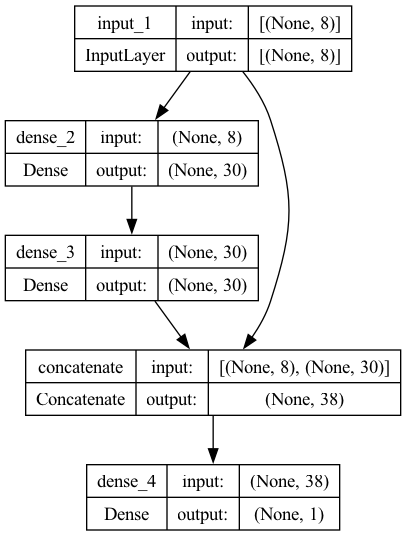

In [13]:
keras.utils.plot_model(model, "regression_model_california_wide_&_deep.png", show_shapes=True)

### Sending a subset of features throught the wide path and a different subset throught the deep path
- one solution to use multiple inputs

In [14]:
input_a = keras.layers.Input(shape=[5], name="wide_input")
input_b = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_b)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_a, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_a, input_b], outputs=[output])

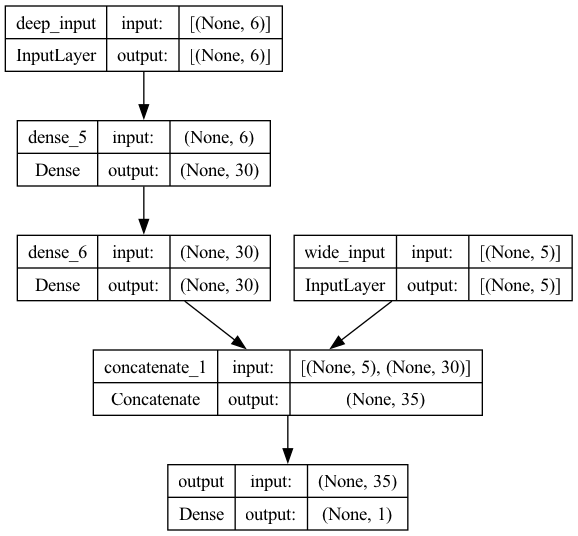

In [15]:
keras.utils.plot_model(model, "regression_model_california_subsetting_features.png", show_shapes=True)

In [16]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.001))

x_train_A, x_train_B = x_train[:, :5], x_train[:, 2:]
x_valid_A, x_valid_B = x_valid[:, :5], x_valid[:, 2:]
x_test_A, x_test_B = x_test[:, :5], x_test[:, 2:]
x_new_A, x_new_B = x_test_A[:3], x_test_B[:3]

history = model.fit((x_train_A, x_train_B), y_train, epochs=20,
                    validation_data=((x_valid_A, x_valid_B), y_valid))
mse_test = model.evaluate((x_test_A, x_test_B), y_test)
y_pred = model.predict((x_new_A, x_new_B))

Epoch 1/20
363/363 [==============================] - 0s 628us/step - loss: 1.8799 - val_loss: 2.1037
Epoch 2/20
363/363 [==============================] - 0s 608us/step - loss: 0.8463 - val_loss: 0.7677
Epoch 3/20
363/363 [==============================] - 0s 593us/step - loss: 0.7386 - val_loss: 0.6834
Epoch 4/20
363/363 [==============================] - 0s 589us/step - loss: 0.6769 - val_loss: 0.6632
Epoch 5/20
363/363 [==============================] - 0s 455us/step - loss: 0.6286 - val_loss: 0.5864
Epoch 6/20
363/363 [==============================] - 0s 448us/step - loss: 0.5879 - val_loss: 0.5537
Epoch 7/20
363/363 [==============================] - 0s 553us/step - loss: 0.5552 - val_loss: 0.5109
Epoch 8/20
363/363 [==============================] - 0s 477us/step - loss: 0.5285 - val_loss: 0.5069
Epoch 9/20
363/363 [==============================] - 0s 450us/step - loss: 0.5081 - val_loss: 0.4708
Epoch 10/20
363/363 [==============================] - 0s 450us/step - loss: 0.491

### Another way is passing an auxilary output for _regularization_
- Could be used for handling multiple outputs

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
input_a = keras.layers.Input(shape=[5], name="wide_input")
input_b = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_b)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_a, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_a, input_b], outputs=[output, aux_output])

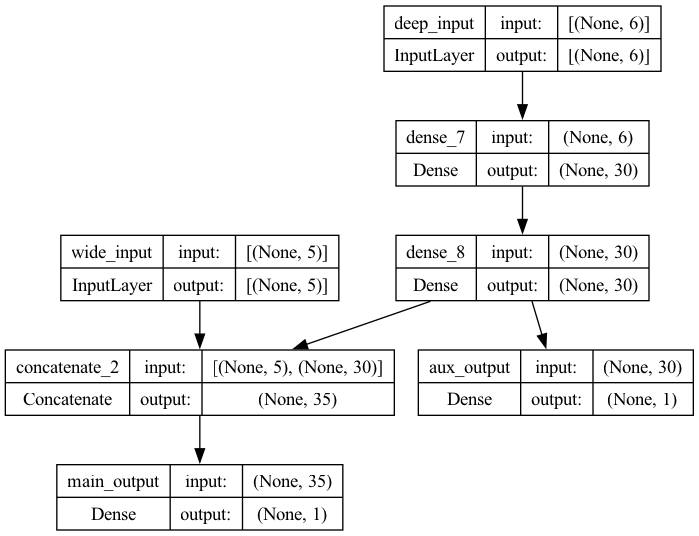

In [19]:
keras.utils.plot_model(model, "regression_model_california_subsetting_features_aux_output.png", show_shapes=True)

### Other info to keep in mind
- loss given during model.compile can be list of loss functions
- During training procide labels for each output, here both main output and aux output should predict the same thing

In [20]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.))

In [21]:
history = model.fit(
    [x_train_A, x_train_B], [y_train, y_train], epochs=20,
    validation_data=([x_valid_A, x_valid_B], [y_valid, y_valid])
)

Epoch 1/20
363/363 [==============================] - 1s 865us/step - loss: 1.5826 - main_output_loss: 1.5090 - aux_output_loss: 2.2455 - val_loss: 1.1097 - val_main_output_loss: 1.1239 - val_aux_output_loss: 0.9824
Epoch 2/20
363/363 [==============================] - 0s 887us/step - loss: 0.4920 - main_output_loss: 0.4663 - aux_output_loss: 0.7231 - val_loss: 3.8046 - val_main_output_loss: 4.1188 - val_aux_output_loss: 0.9771
Epoch 3/20
363/363 [==============================] - 0s 737us/step - loss: 0.4467 - main_output_loss: 0.4311 - aux_output_loss: 0.5870 - val_loss: 3.8293 - val_main_output_loss: 4.1954 - val_aux_output_loss: 0.5342
Epoch 4/20
363/363 [==============================] - 0s 879us/step - loss: 0.4215 - main_output_loss: 0.4085 - aux_output_loss: 0.5388 - val_loss: 2.4795 - val_main_output_loss: 2.6216 - val_aux_output_loss: 1.2010
Epoch 5/20
363/363 [==============================] - 0s 611us/step - loss: 0.3970 - main_output_loss: 0.3846 - aux_output_loss: 0.5087 

In [22]:
total_loss, main_loss, aux_loss = model.evaluate([x_test_A, x_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([x_new_A, x_new_B])

1/1 [==============================] - 0s 35ms/step


In [23]:
x_test_A.shape, x_test_B.shape, y_test.shape

((5160, 5), (5160, 6), (5160,))

### Using Subclassing API to build Dynamic Models

In [24]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation='relu')

In [26]:
model.compile(loss='mse', loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((x_train_A, x_train_B), (y_train, y_train), epochs=10, validation_data=((x_valid_A, x_valid_B),(y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((x_test_A, x_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((x_new_A, x_new_B))

Epoch 1/10
363/363 [==============================] - 1s 810us/step - loss: 1.9668 - output_1_loss: 1.8204 - output_2_loss: 3.2844 - val_loss: 1.4048 - val_output_1_loss: 1.3132 - val_output_2_loss: 2.2290
Epoch 2/10
363/363 [==============================] - 0s 657us/step - loss: 0.8902 - output_1_loss: 0.7526 - output_2_loss: 2.1280 - val_loss: 0.7969 - val_output_1_loss: 0.6850 - val_output_2_loss: 1.8043
Epoch 3/10
363/363 [==============================] - 0s 550us/step - loss: 0.7569 - output_1_loss: 0.6480 - output_2_loss: 1.7376 - val_loss: 0.7016 - val_output_1_loss: 0.6065 - val_output_2_loss: 1.5568
Epoch 4/10
363/363 [==============================] - 0s 582us/step - loss: 0.6876 - output_1_loss: 0.5952 - output_2_loss: 1.5190 - val_loss: 0.6774 - val_output_1_loss: 0.5983 - val_output_2_loss: 1.3889
Epoch 5/10
363/363 [==============================] - 0s 591us/step - loss: 0.6459 - output_1_loss: 0.5647 - output_2_loss: 1.3764 - val_loss: 0.6073 - val_output_1_loss: 0.531

1/1 [==============================] - 0s 33ms/step


### Adding callbacks

- ModelCheckpoints
- EarlyStopping
- Custom callback (ratio of validation loss and training loss furing training) 

### Tensorboard

In [36]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [37]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2024_09_02-17_59_49'

In [38]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [39]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/50
363/363 [==============================] - 1s 688us/step - loss: 2.7310 - val_loss: 1.8708
Epoch 2/50
363/363 [==============================] - 0s 488us/step - loss: 0.7454 - val_loss: 0.6184
Epoch 3/50
363/363 [==============================] - 0s 488us/step - loss: 0.5708 - val_loss: 0.5479
Epoch 4/50
363/363 [==============================] - 0s 627us/step - loss: 0.5316 - val_loss: 0.5103
Epoch 5/50
363/363 [==============================] - 0s 479us/step - loss: 0.5099 - val_loss: 0.4734
Epoch 6/50
363/363 [==============================] - 0s 472us/step - loss: 0.4917 - val_loss: 0.4590
Epoch 7/50
363/363 [==============================] - 0s 472us/step - loss: 0.4772 - val_loss: 0.4469
Epoch 8/50
363/363 [==============================] - 0s 479us/step - loss: 0.4648 - val_loss: 0.4279
Epoch 9/50
363/363 [==============================] - 0s 470us/step - loss: 0.4538 - val_loss: 0.4172
Epoch 10/50
363/363 [==============================] - 0s 509us/step - loss: 0.444

In [33]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
